# Actual

**Dataset Download Link**
[https://drive.google.com/file/d/1ULKLK_R0qsLho6PzfUIOwTXOStk3w5jd/view?usp=sharing](https://drive.google.com/file/d/1ULKLK_R0qsLho6PzfUIOwTXOStk3w5jd/view?usp=sharing)

### Import Liraries

In [18]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.compat.v1.keras.backend import set_session

### Allow GPU Processing

In [19]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True # dynamically grow the memory used on the GPU
config.log_device_placement = True # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping: no known devices.


### Read Images

In [20]:
my_data_dir = "./cell_images"

In [21]:
os.listdir(my_data_dir)

['test', 'train']

In [22]:
test_path = my_data_dir+'/test/'
train_path = my_data_dir+'/train/'

In [23]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [24]:
len(os.listdir(train_path+'/uninfected/'))

12479

In [25]:
len(os.listdir(train_path+'/parasitized/'))

12479

In [26]:
os.listdir(train_path+'/parasitized')[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [27]:
para_img= imread(train_path+
                 '/parasitized/'+
                 os.listdir(train_path+'/parasitized')[0])

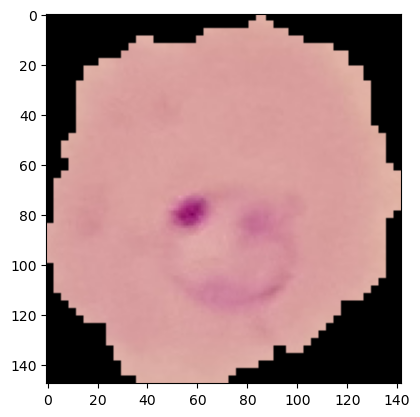

In [28]:
plt.imshow(para_img)

### Checking the image dimensions

In [29]:
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'/uninfected'):
    img = imread(test_path+'/uninfected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

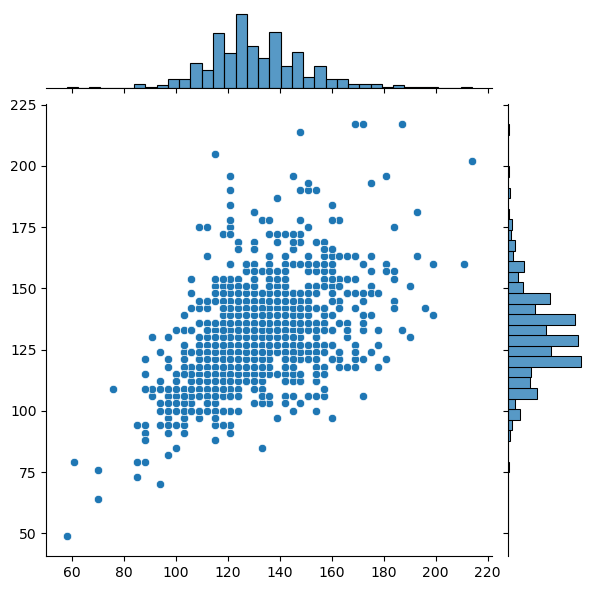

In [30]:
sns.jointplot(x=dim1,y=dim2)

In [31]:
image_shape = (130,130,3)

### Image Generator

In [32]:
help(ImageDataGenerator)

Help on class ImageDataGenerator in module keras.preprocessing.image:

class ImageDataGenerator(builtins.object)
 |  ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, interpolation_order=1, dtype=None)
 |  
 |  Generate batches of tensor image data with real-time data augmentation.
 |  
 |  Deprecated: `tf.keras.preprocessing.image.ImageDataGenerator` is not
 |  recommended for new code. Prefer loading images with
 |  `tf.keras.utils.image_dataset_from_directory` and transforming the output
 |  `tf.data.Dataset` with preprocessing layers. For more informati

In [33]:
image_gen = ImageDataGenerator(rotation_range=20,         # rotate the image 20 degrees
                               width_shift_range=0.10,    # Shift the pic width by a max of 5%
                               height_shift_range=0.10,   # Shift the pic height by a max of 5%
                               rescale=1/255,             # Rescale the image by normalzing it.
                               shear_range=0.1,           # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1,            # Zoom in by 10% max
                               horizontal_flip=True,      # Allo horizontal flipping
                               fill_mode='nearest'        # Fill in missing pixels with the nearest filled value
                              )

In [34]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [35]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


### DL Model - Build & Compile

In [36]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(128))
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))

model.add(layers.Dropout(0.5))

model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)      

In [38]:
batch_size = 16

In [39]:
help(image_gen.flow_from_directory)

Help on method flow_from_directory in module keras.preprocessing.image:

flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest', keep_aspect_ratio=False) method of keras.preprocessing.image.ImageDataGenerator instance
    Takes the path to a directory & generates batches of augmented data.
    
    Args:
        directory: string, path to the target directory. It should contain one
          subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images inside
          each of the subdirectories directory tree will be included in the
          generator. See [this script](
            https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)
              for more details.
        target_size: Tuple of integers `(height, width)`, defaults to `(256,
          256)`. The dime

### Fit the model

In [40]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='binary')

Found 24958 images belonging to 2 classes.


In [41]:
train_image_gen.batch_size

16

In [42]:
len(train_image_gen.classes)

24958

In [43]:
train_image_gen.total_batches_seen

0

In [44]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [45]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [48]:
results = model.fit(train_image_gen,epochs=2,validation_data=test_image_gen)

Epoch 1/2
1560/1560 [==============================] - 286s 183ms/step - loss: 0.1716 - accuracy: 0.9482 - val_loss: 0.1744 - val_accuracy: 0.9454
Epoch 2/2
1560/1560 [==============================] - 254s 163ms/step - loss: 0.1672 - accuracy: 0.9490 - val_loss: 0.1856 - val_accuracy: 0.9446


In [49]:
model.save('cell_model.h5')

### Plot the graphs

In [50]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

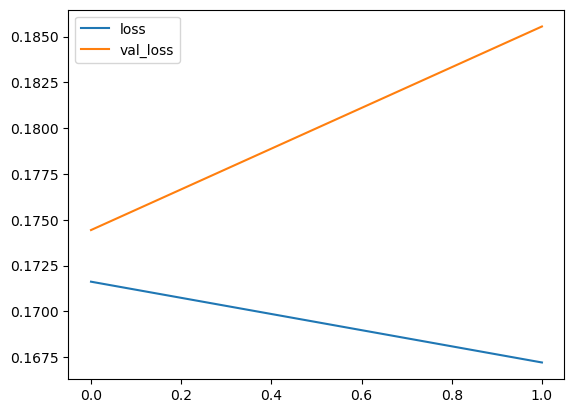

In [51]:
losses[['loss','val_loss']].plot()

In [52]:
model.metrics_names

['loss', 'accuracy']

### Evaluate Metrics

In [53]:
model.evaluate(test_image_gen)

163/163 [==============================] - 19s 118ms/step - loss: 0.1724 - accuracy: 0.9442


[0.17239178717136383, 0.9442307949066162]

In [54]:
pred_probabilities = model.predict(test_image_gen)

163/163 [==============================] - 23s 139ms/step


In [55]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [56]:
predictions = pred_probabilities > 0.5

In [57]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94      1300
           1       0.92      0.97      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



In [58]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1188,  112],
       [  45, 1255]], dtype=int64)

### Check for custom image

1/1 [==============================] - 0s 87ms/step


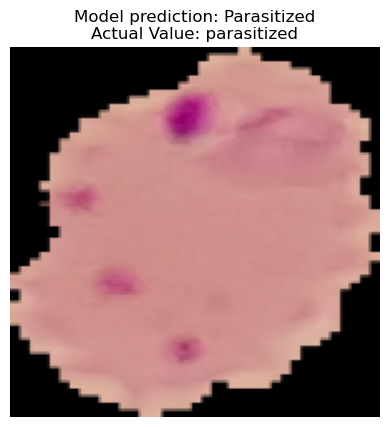

In [59]:
import random
import tensorflow as tf

list_dir=["Un Infected","parasitized"]
dir_=(random.choice(list_dir))
para_img= imread(train_path+
                 '/'+dir_+'/'+
                 os.listdir(train_path+'/'+dir_)[random.randint(0,100)])
img  = tf.convert_to_tensor(np.asarray(para_img))
img = tf.image.resize(img,(130,130))
img=img.numpy()
pred=bool(model.predict(img.reshape(1,130,130,3))<0.5 )
plt.title("Model prediction: "+("Parasitized" if pred  else "Un Infected")+"\nActual Value: "+str(dir_))
plt.axis("off")
plt.imshow(img)
plt.show()    